<a href="https://colab.research.google.com/github/9M3a1h3d9i9/HGNN/blob/main/EEG_dataset_HGNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# بسم الله الرحمن الرحیم

## نمایش دادگان سیگنال های مغز با استفاده از شبکه گرافی ناهمگون
## محمد مهدی شفیقی

#نصب کتابخانه های مورد نیاز

In [1]:
!pip install mne torch torch_geometric networkx matplotlib numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.

# Introduction and Initial Setup

In this notebook, we will create a heterogeneous graph from EEG data, visualize it, and optionally run a Graph Neural Network (GNN) model on it. The steps include loading EEG data, processing it, building a graph, displaying it with colors, and applying a GNN if desired.

First, we need to import the necessary Python libraries:
- `mne`: For loading and processing EEG data.
- `numpy`: For handling numerical data.
- `torch`: For tensor operations in PyTorch.
- `torch_geometric`: For working with graph data.
- `networkx` and `matplotlib`: For graph visualization.

In [2]:
import mne
import numpy as np
import torch
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn import HGTConv
import torch.nn.functional as F

# Loading and Processing EEG Data

Here, we load real EEG data using the `mne` library. If real data isn’t available, we’ll use dummy data instead. The EEG data will be an array with shape `(number of channels, number of time points)`. We’ll also get the names of the EEG channels.

- We try to load a sample dataset from `mne`.
- If that fails, we create fake data with 60 electrodes and 1000 time points.

In [3]:
try:
    # Load sample EEG data from MNE
    sample_data_folder = mne.datasets.sample.data_path()
    sample_data_raw_file = sample_data_folder / 'MEG' / 'sample' / 'sample_audvis_raw.fif'
    raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)

    # Select only EEG channels
    eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False)
    raw_eeg = raw.copy().pick(eeg_picks)

    # Get the data array and channel names
    data_array = raw_eeg.get_data()  # Shape: (n_channels, n_times)
    channel_names = raw_eeg.ch_names

    print(f"Loaded EEG data shape: {data_array.shape}")
    print(f"Channel names: {channel_names}")

except Exception as e:
    print(f"Error loading or processing EEG data: {e}")
    print("Please ensure MNE-Python is installed and you have a valid EEG data file.")
    print("Using dummy data for demonstration.")
    # Create dummy data if loading fails
    num_electrodes = 60
    n_times = 1000
    data_array = np.random.randn(num_electrodes, n_times) * 1e-5  # Simulated microvolts
    channel_names = [f'EEG {i:03d}' for i in range(num_electrodes)]

Using default location ~/mne_data for sample...
Creating /root/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 1.78TB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 01m36s (1576.2 MB)
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Loaded EEG data shape: (59, 166800)
Channel names: ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016', 'EEG 017', 'EEG 018', 'EEG 019', 'EEG 020', 'EEG 021', 'EEG 022', 'EEG 023', 'EEG 024', 'EEG 025', 'EEG 026', 'EEG 027', 'EEG 028', 'EEG 029', 'EEG 030', 'EEG 031', 'EEG 032', 'EEG 033', 'EEG 034', 'EEG 035', 'EEG 036', 'EEG 037', 'EEG 038', 'EEG 039', 'EEG 040', 'EEG 041', 'EEG 042', 'EEG 043', 'EEG 

# Extracting Features and Defining the Graph Structure

In this section, we define features for the nodes and edges of our graph:
- **Electrode Features**: We calculate the average amplitude for each electrode across frequency bands (simplified here).
- **Frequency Band Features**: We use the min and max frequency ranges for each band.
- **Edges**:
  - **Electrode-to-Electrode**: Based on correlation between electrode signals (threshold = 0.6).
  - **Electrode-to-Frequency Band**: Every electrode connects to every frequency band.
  - **Frequency Band-to-Electrode**: The reverse connection (same as above for simplicity).

We define five frequency bands: Delta, Theta, Alpha, Beta, and Gamma.

In [4]:
# Define frequency bands
frequency_bands = {
    'Delta': [1, 4],
    'Theta': [4, 8],
    'Alpha': [8, 13],
    'Beta': [13, 30],
    'Gamma': [30, 45]
}
frequency_band_names = list(frequency_bands.keys())
num_frequency_bands = len(frequency_band_names)
num_electrodes = data_array.shape[0]

# Electrode features: Simplified as mean amplitude per band
electrode_features = np.zeros((num_electrodes, num_frequency_bands))
sfreq = raw_eeg.info['sfreq'] if 'raw_eeg' in locals() else 1000.

for i, (band_name, (fmin, fmax)) in enumerate(frequency_bands.items()):
    # Simplified feature: mean absolute amplitude with slight noise
    electrode_features[:, i] = np.mean(np.abs(data_array[:, int(sfreq*0.1):int(sfreq*0.9)]), axis=1) + np.random.rand(num_electrodes) * 1e-6

# Frequency band features: Min and max frequencies
frequency_band_features = np.array([[fmin, fmax] for fmin, fmax in frequency_bands.values()])

# Convert features to PyTorch tensors
electrode_features_tensor = torch.tensor(electrode_features, dtype=torch.float)
frequency_band_features_tensor = torch.tensor(frequency_band_features, dtype=torch.float)

# Electrode-to-electrode edges based on correlation
electrode_connectivity_matrix = np.corrcoef(data_array)
connectivity_threshold = 0.6
electrode_to_electrode_edge_list = [
    [i, j] for i in range(num_electrodes) for j in range(i + 1, num_electrodes)
    if np.abs(electrode_connectivity_matrix[i, j]) > connectivity_threshold
]
electrode_to_electrode_edge_index = torch.tensor(electrode_to_electrode_edge_list, dtype=torch.long).t().contiguous() if electrode_to_electrode_edge_list else None
print(f"Created {electrode_to_electrode_edge_index.size(1) if electrode_to_electrode_edge_index is not None else 0} electrode-to-electrode edges.")

# Electrode-to-frequency band edges
electrode_to_frequency_edge_list = [
    [i, j] for i in range(num_electrodes) for j in range(num_frequency_bands)
]
electrode_to_frequency_edge_index = torch.tensor(electrode_to_frequency_edge_list, dtype=torch.long).t().contiguous()
print(f"Created {electrode_to_frequency_edge_index.size(1)} electrode-to-frequency_band edges.")

# Frequency band-to-electrode edges (reverse)
frequency_to_electrode_edge_index = electrode_to_frequency_edge_index
print(f"Created {frequency_to_electrode_edge_index.size(1)} frequency_band-to-electrode edges.")

Created 1696 electrode-to-electrode edges.
Created 295 electrode-to-frequency_band edges.
Created 295 frequency_band-to-electrode edges.


# Building the Heterogeneous Graph

Now, we create a `HeteroData` object to represent our heterogeneous graph. This object stores:
- Node features for electrodes and frequency bands.
- Edge indices for the relationships between nodes.

The graph has two node types (`electrode` and `frequency_band`) and three edge types:
- `electrode -- connects --> electrode`
- `electrode -- has_activity_in --> frequency_band`
- `frequency_band -- influences --> electrode`

In [5]:
data = HeteroData()

# Add node features
data['electrode'].x = electrode_features_tensor
data['frequency_band'].x = frequency_band_features_tensor

# Add edge indices
if electrode_to_electrode_edge_index is not None:
    data['electrode', 'connects', 'electrode'].edge_index = electrode_to_electrode_edge_index
data['electrode', 'has_activity_in', 'frequency_band'].edge_index = electrode_to_frequency_edge_index
data['frequency_band', 'influences', 'electrode'].edge_index = frequency_to_electrode_edge_index

print("\nConstructed HeteroData object:")
print(data)


Constructed HeteroData object:
HeteroData(
  electrode={ x=[59, 5] },
  frequency_band={ x=[5, 2] },
  (electrode, connects, electrode)={ edge_index=[2, 1696] },
  (electrode, has_activity_in, frequency_band)={ edge_index=[2, 295] },
  (frequency_band, influences, electrode)={ edge_index=[2, 295] }
)


# Visualizing the Graph with NetworkX

We convert the `HeteroData` object into a `NetworkX` graph for visualization:
- **Nodes**: Electrodes (skyblue) and frequency bands (lightgreen).
- **Edges**: Colored based on type (red, blue, green).
- A layout is used to position the nodes, and labels show channel or band names.

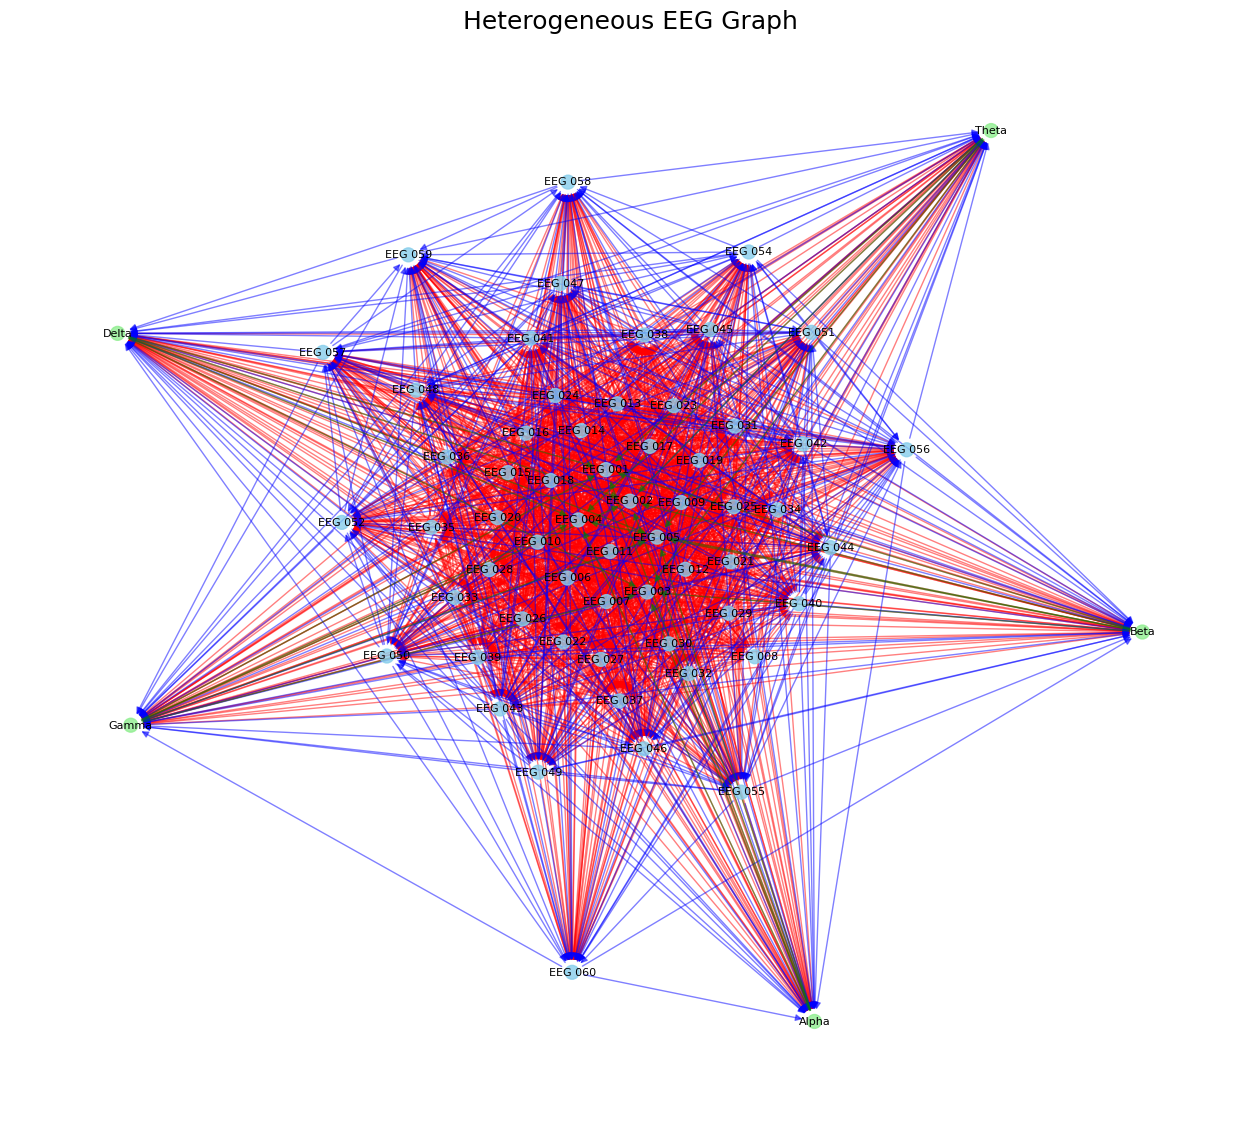

In [9]:
G = nx.DiGraph()

# Add nodes
for i in range(data['electrode'].num_nodes):
    node_name = f'electrode_{i}'
    display_name = channel_names[i] if i < len(channel_names) else node_name
    G.add_node(node_name, type='electrode', original_name=display_name)

for i in range(data['frequency_band'].num_nodes):
    node_name = f'frequency_band_{i}'
    display_name = frequency_band_names[i] if i < len(frequency_band_names) else node_name
    G.add_node(node_name, type='frequency_band', original_name=display_name)

# Add edges with colors
edge_color_map = {
    ('electrode', 'connects', 'electrode'): 'red',
    ('electrode', 'has_activity_in', 'frequency_band'): 'blue',
    ('frequency_band', 'influences', 'electrode'): 'green',
}
edge_colors = []

for edge_type, edge_index in data.edge_index_dict.items():
    if edge_index is None:
        continue
    src_type, edge_name, tgt_type = edge_type
    current_edge_color = edge_color_map.get(edge_type, 'gray')
    for i in range(edge_index.size(1)):
        src_idx = edge_index[0, i].item()
        tgt_idx = edge_index[1, i].item()
        src_node = f'{src_type}_{src_idx}'
        tgt_node = f'{tgt_type}_{tgt_idx}'
        if src_node in G and tgt_node in G:
            G.add_edge(src_node, tgt_node, type=edge_name)
            edge_colors.append(current_edge_color)

# Set node colors and labels
node_colors = []
node_labels = {}
for node_name, attributes in G.nodes(data=True):
    node_type = attributes['type']
    display_name = attributes.get('original_name', node_name)
    if node_type == 'electrode':
        node_colors.append('skyblue')
    elif node_type == 'frequency_band':
        node_colors.append('lightgreen')
    node_labels[node_name] = display_name

# Draw the graph
plt.figure(figsize=(16, 14))
pos = nx.spring_layout(G, k=0.3, iterations=50)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.0, alpha=0.5)
if G.number_of_nodes() < 100:
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
plt.title("Heterogeneous EEG Graph", fontsize=18)
plt.axis('off')
plt.show()

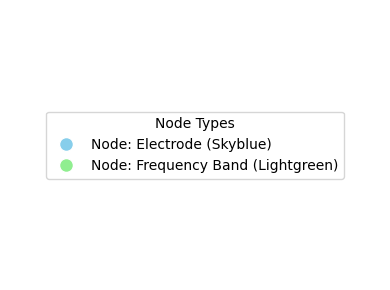

In [11]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Create Node Type Legend ---
fig_nodes, ax_nodes = plt.subplots(figsize=(4, 3)) # Small figure for node legend

legend_elements_nodes = [
    Line2D([0], [0], marker='o', color='w', label='Node: Electrode (Skyblue)',
           markerfacecolor='skyblue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Node: Frequency Band (Lightgreen)',
           markerfacecolor='lightgreen', markersize=10)
]

# Add the legend to the axis
legend_nodes = ax_nodes.legend(handles=legend_elements_nodes, loc='center', title="Node Types", fontsize=10)

# Hide the axes
ax_nodes.axis('off')
fig_nodes.tight_layout()
plt.show()

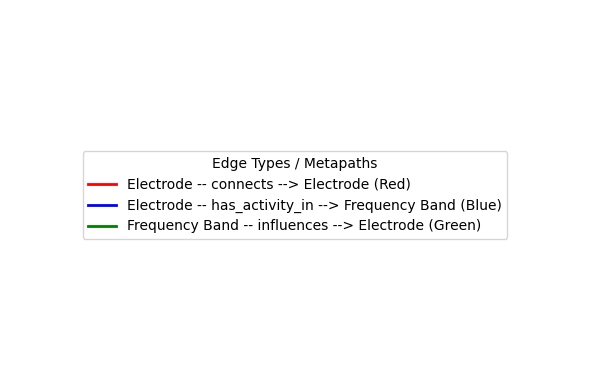

In [12]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Create Edge Type / Metapath Legend ---
fig_edges, ax_edges = plt.subplots(figsize=(6, 4)) # Small figure for edge/metapath legend

edge_legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Electrode -- connects --> Electrode (Red)'),
    Line2D([0], [0], color='blue', lw=2, label='Electrode -- has_activity_in --> Frequency Band (Blue)'),
    Line2D([0], [0], color='green', lw=2, label='Frequency Band -- influences --> Electrode (Green)')
]

# Add the legend to the axis
legend_edges = ax_edges.legend(handles=edge_legend_elements, loc='center', title="Edge Types / Metapaths", fontsize=10)

# Hide the axes
ax_edges.axis('off')
fig_edges.tight_layout()
plt.show()

# (Optional) Defining and Running a GNN Model

This section is optional. We define a simple GNN model using `HGTConv` from `torch_geometric` and run it on our graph. The model processes the node features and outputs new features. Note: This requires labels and a loss function for training, which aren’t included here.